In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import os
import platform

In [2]:
if platform.system() == 'Linux':
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [7]:
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [5]:
if platform.system() == 'Linux':
  root = '/content/drive/MyDrive/deep learning/pytorch_course/PYTORCH_NOTEBOOKS/PYTORCH_NOTEBOOKS/Data/CATS_DOGS/CATS_DOGS'
else:
  root = '../../PYTORCH_NOTEBOOKS/PYTORCH_NOTEBOOKS/Data/CATS_DOGS/CATS_DOGS'


train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)


class_names = train_data.classes # get the two tags from the folders
class_names

['CAT', 'DOG']

In [ ]:
len(train_data)

18743

In [ ]:
len(test_data)

6251

Grab a batch for applying the transformations as an example

In [ ]:
for images, labels in train_loader:
    break

In [ ]:
images.shape

torch.Size([10, 3, 224, 224])

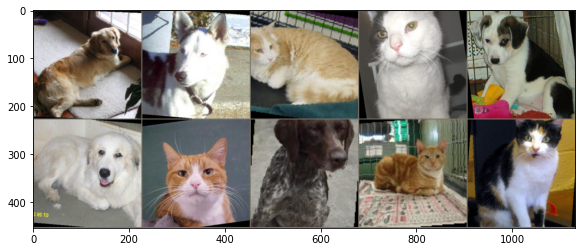

In [ ]:
im = make_grid(images, nrow =5)
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));


### Get the size of the images after the convolutional and pooling layers

In [ ]:
(((224-2)/2)-2)/2

54.5

In [3]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(54*54*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim =1)

In [7]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_params = 0
for param in model.parameters():
    num_params += param.numel()
    print(param.numel())
print(f'The network it has {num_params} parameters')

162
6
864
16
5598720
120
10080
84
168
2
The network it has 5610222 parameters


In [ ]:
import time
start_time = time.time()

# Trackers
epochs = 5
# limits the num of batches
max_trn_batch = 800 # batch 10 img --> 8000 images
max_tst_batch = 300 # 3000 max images

train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For loop epochs
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # train
    for b, (X_train, y_train) in enumerate(train_loader):
        # OPTIONAL LIMIT NUMBER OF BATCHES
        if b == max_trn_batch:
            break

        b+= 1
        y_pred = model(X_train) # no flat
        loss = criterion(y_pred, y_train)
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum() # true / false pick the trues and sum them
        trn_corr += batch_corr

        # the back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \ accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # test
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            b += 1

            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

        loss = criterion(y_val, y_test)
        test_losses.append(loss)
        test_correct.append(tst_corr)




current_time = time.time()
total = current_time - start_time
print(f"Training took {total/60} minutes")

epoch:  0  batch:  200 [  2000/50000]  loss: 0.62408704  \ accuracy:  55.950%
epoch:  0  batch:  400 [  4000/50000]  loss: 0.54988575  \ accuracy:  57.600%
epoch:  0  batch:  600 [  6000/50000]  loss: 0.68310481  \ accuracy:  60.767%
epoch:  0  batch:  800 [  8000/50000]  loss: 0.40706199  \ accuracy:  62.125%
epoch:  1  batch:  200 [  2000/50000]  loss: 0.60552710  \ accuracy:  68.500%
epoch:  1  batch:  400 [  4000/50000]  loss: 0.86509669  \ accuracy:  69.475%
epoch:  1  batch:  600 [  6000/50000]  loss: 0.60582393  \ accuracy:  69.950%
epoch:  1  batch:  800 [  8000/50000]  loss: 0.56921780  \ accuracy:  70.675%
epoch:  2  batch:  200 [  2000/50000]  loss: 0.42176157  \ accuracy:  75.250%
epoch:  2  batch:  400 [  4000/50000]  loss: 0.58291256  \ accuracy:  74.100%
epoch:  2  batch:  600 [  6000/50000]  loss: 0.67117602  \ accuracy:  74.150%
epoch:  2  batch:  800 [  8000/50000]  loss: 0.43578616  \ accuracy:  74.112%
epoch:  3  batch:  200 [  2000/50000]  loss: 0.53765815  \ accur

In [ ]:
# save of colab
if platform.system() == 'Linux':
  torch.save(model.state_dict(), '/content/drive/MyDrive/deep learning/pytorch_course/my files/rnc/CAT_OR_DOG.pt')
else:
  torch.save(model.state_dict(), 'CAT_OR_DOG.pt')

In [4]:
model = ConvolutionalNetwork()

# load the model
if platform.system() == 'Linux':
  model.load_state_dict(torch.load('/content/drive/MyDrive/deep learning/pytorch_course/my files/rnc/CAT_OR_DOG.pt'))
else:
  model.load_state_dict(torch.load('CAT_OR_DOG.pt'))


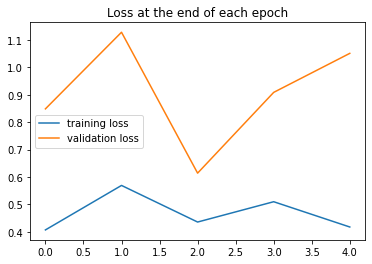

In [ ]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

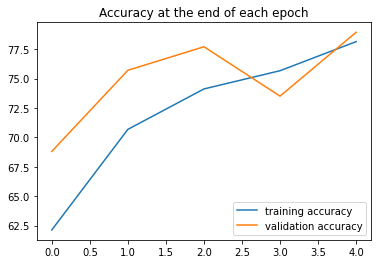

In [ ]:
plt.plot([t/80 for t in train_correct], label='training accuracy')
plt.plot([t/30 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [ ]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/3000:.3f}%')

[tensor(2064), tensor(2271), tensor(2331), tensor(2205), tensor(2368)]
Test accuracy: 78.933%


### Pre trained models
use Alexnet for our own images

In [28]:
AlexNetmodel = models.alexnet(pretrained=True)

Here we have to freeze the weights and bias because they don't have to change with the new images

In [29]:
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [30]:
for param in AlexNetmodel.parameters():
    param.requires_grad = False

Modify the last part in the net for adapting it to the cat or dog problem

In [31]:
torch.manual_seed(42)

AlexNetmodel.classifier = nn.Sequential(nn.Linear(9216, 1024),
                                        nn.ReLU(),
                                        nn.Dropout(0.5),
                                        nn.Linear(1024, 2),
                                        nn.LogSoftmax(dim=1),)

In [33]:
for param in AlexNetmodel.parameters():
    print(param.numel())

23232
64
307200
192
663552
384
884736
256
589824
256
9437184
1024
2048
2


In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetmodel.classifier.parameters(), lr=0.001)

In [35]:
import time
start_time = time.time()

# Trackers
epochs = 1
# limits the num of batches
max_trn_batch = 800 # batch 10 img --> 8000 images
max_tst_batch = 300 # 3000 max images

train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For loop epochs
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # train
    for b, (X_train, y_train) in enumerate(train_loader):
        # OPTIONAL LIMIT NUMBER OF BATCHES
        if b == max_trn_batch:
            break

        b+= 1
        y_pred = AlexNetmodel(X_train) # no flat
        loss = criterion(y_pred, y_train)
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum() # true / false pick the trues and sum them
        trn_corr += batch_corr

        # the back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \ accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # test
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            b += 1

            y_val = AlexNetmodel(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

        loss = criterion(y_val, y_test)
        test_losses.append(loss)
        test_correct.append(tst_corr)




current_time = time.time()
total = current_time - start_time
print(f"Training took {total/60} minutes")

epoch:  0  batch:  200 [  2000/50000]  loss: 0.31619117  \ accuracy:  88.700%
epoch:  0  batch:  400 [  4000/50000]  loss: 0.13053176  \ accuracy:  90.250%
epoch:  0  batch:  600 [  6000/50000]  loss: 0.27683461  \ accuracy:  90.983%
epoch:  0  batch:  800 [  8000/50000]  loss: 0.01247102  \ accuracy:  91.625%
Training took 70.84597361087799 minutes


In [36]:
# save of colab
if platform.system() == 'Linux':
  torch.save(AlexNetmodel.state_dict(), '/content/drive/MyDrive/deep learning/pytorch_course/my files/rnc/CAT_OR_DOG_ALEXNET.pt')
else:
  torch.save(AlexNetmodel.state_dict(), 'CAT_OR_DOG_ALEXNET.pt')

In [32]:
AlexNetmodel = models.alexnet(pretrained=True)
torch.manual_seed(42)

AlexNetmodel.classifier = nn.Sequential(nn.Linear(9216, 1024),
                                        nn.ReLU(),
                                        nn.Dropout(0.5),
                                        nn.Linear(1024, 2),
                                        nn.LogSoftmax(dim=1),)
# load the model
if platform.system() == 'Linux':
  AlexNetmodel.load_state_dict(torch.load('/content/drive/MyDrive/deep learning/pytorch_course/my files/rnc/CAT_OR_DOG_ALEXNET.pt'))
else:
  AlexNetmodel.load_state_dict(torch.load('CAT_OR_DOG_ALEXNET.pt'))


In [42]:
image_index = 2019

im = inv_normalize(test_data[image_index][0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

NameError: ignored

In [39]:
model.eval()
with torch.no_grad():
  new_pred = model(test_data[image_index][0].view(1, 3, 224, 224)).argmax()

class_names[new_pred.item()]

'CAT'

In [44]:
AlexNetmodel.eval()
with torch.no_grad():
  new_pred = model(test_data[image_index][0].view(1, 3, 224, 224)).argmax()

class_names[new_pred.item()]

'CAT'

In [10]:
if platform.system() == 'Linux':
  root = '/content/drive/MyDrive/deep learning/pytorch_course/PYTORCH_NOTEBOOKS/PYTORCH_NOTEBOOKS/Data/CATS_DOGS/single_prediction'
else:
  root = '../../PYTORCH_NOTEBOOKS/PYTORCH_NOTEBOOKS/Data/CATS_DOGS/single_prediction'


single_prediction_data = datasets.ImageFolder(os.path.join(root), transform=test_transform)


torch.manual_seed(42)
single_prediction_loader = DataLoader(single_prediction_data)



class_names = single_prediction_data.classes # get the two tags from the folders
class_names

['cat', 'dog']

Test my model with the custom images

In [31]:
correct = 0
with torch.no_grad():
    for X_test, y_test in single_prediction_loader:
        y_pred = model(X_test)
        predicted = torch.max(y_pred.data, 1)[1]
        correct += (predicted == y_test[0])
        print(f'{class_names[predicted]} -- {class_names[y_test]}')
print (f'{correct[0]} of {len(single_prediction_data)}')
print(correct.item()/len(single_prediction_data)*100)



cat -- cat
cat -- cat
cat -- cat
cat -- cat
cat -- cat
cat -- cat
cat -- cat
cat -- cat
dog -- cat
dog -- dog
cat -- dog
dog -- dog
dog -- dog
dog -- dog
dog -- dog
cat -- dog
cat -- dog
dog -- dog
14 of 18
77.77777777777779


Test the Alexnet model with the custom images

In [34]:
correct = 0
with torch.no_grad():
    for X_test, y_test in single_prediction_loader:
        y_pred = AlexNetmodel(X_test)
        predicted = torch.max(y_pred.data, 1)[1]
        correct += (predicted == y_test[0])
        print(f'{class_names[predicted]} -- {class_names[y_test]}')
print (f'{correct[0]} of {len(single_prediction_data)}')
print(correct.item()/len(single_prediction_data)*100)



cat -- cat
cat -- cat
cat -- cat
cat -- cat
cat -- cat
cat -- cat
cat -- cat
cat -- cat
cat -- cat
dog -- dog
dog -- dog
dog -- dog
dog -- dog
dog -- dog
dog -- dog
dog -- dog
cat -- dog
dog -- dog
17 of 18
94.44444444444444
